#CNN - Object Detection - Part 4
#### • DOMAIN:
> State traffic department
#### • CONTEXT:
> City X’s traffic department wants to understand the traffic density on road during busy hours in order to efficiently program
their traffic lights.
#### • TASK:
> Create an automation using computer vision to impute dynamic bounding boxes to locate cars or vehicles on the road. It would
require for you to do some research on how to impute bounding boxes on video file. You can use video provided with this assignment or any video of your choice which has moving cars to impute bounding boxes.

***Refer to the screenshot from sample video below:***
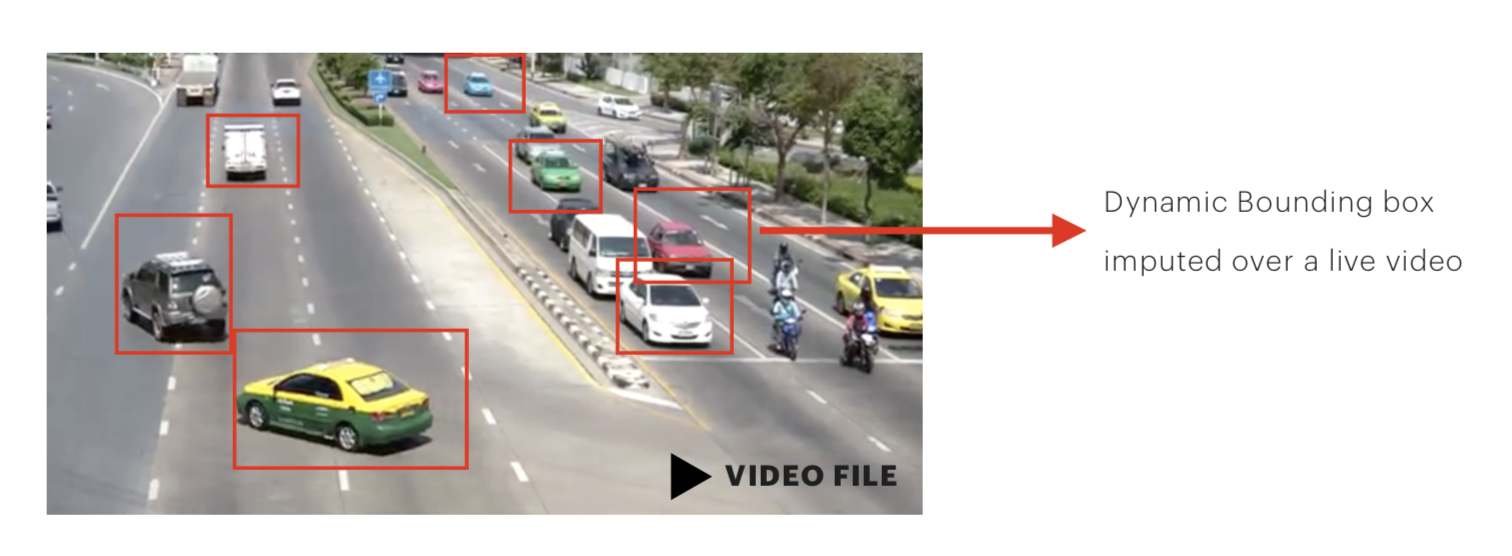

# (1) Import Python Libraries

In [14]:
import numpy as np
import pandas as pd
import cv2
from zipfile import ZipFile
import os
from google.colab.patches import cv2_imshow
from IPython.display import Image, display, Markdown, clear_output, HTML
from base64 import b64encode
from tqdm.notebook import tqdm
from pathlib import Path
from time import sleep
import subprocess


# (2) Set path parameters and load The video file

## (2.1) Mount the Google Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## (2.2) Set path parameters

In [16]:
project_path = '/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_4'
zip_file = '/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_4/Part 4 Video.zip'
base_path = '/content'

## (2.3) Unzip the video file

In [17]:
video_file_path = os.path.join(project_path, zip_file)
with ZipFile(video_file_path, 'r') as z:
  z.extractall()

In [18]:
unzip_loc = os.path.join('/content',z.filelist[0].filename.split('/')[0])
video_1 = os.path.join(unzip_loc,'video1.mp4')
video_2 = os.path.join(unzip_loc,'video2.mp4')
video_1, video_2

('/content/Video/video1.mp4', '/content/Video/video2.mp4')

## (2.4) Import the "cars.xml" model file from the GitHub 

In [19]:
os.chdir(project_path)
if not os.path.exists(os.path.join(project_path,'cars.xml')):
  display(Markdown('#### cars.xml file not found in the project path.. Downloading it from the github '))
  os.system('wget https://raw.githubusercontent.com/chandravenky/Computer-Vision---Object-Detection-in-Python/master/xml%20files/cars.xml')
else:
  display(Markdown('#### cars.xml file found in the project path'))


#### cars.xml file found in the project path

## (2.5) Helper function to play the video file in the notebook environment.

#### This is a little hack in the Jupyter Notebook environment. This is due to the fact that `cv2.imshow` or `cv2_imshow` does not work well in this environment. 

In [20]:
def show_movie(movie,size=400):
  mp4 = open(movie, "rb").read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  display(HTML(f"""
  <video width={size} controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """))

In [21]:
input_video = video_2
input_video

'/content/Video/video2.mp4'

In [22]:
show_movie(input_video,size=400)


Output hidden; open in https://colab.research.google.com to view.

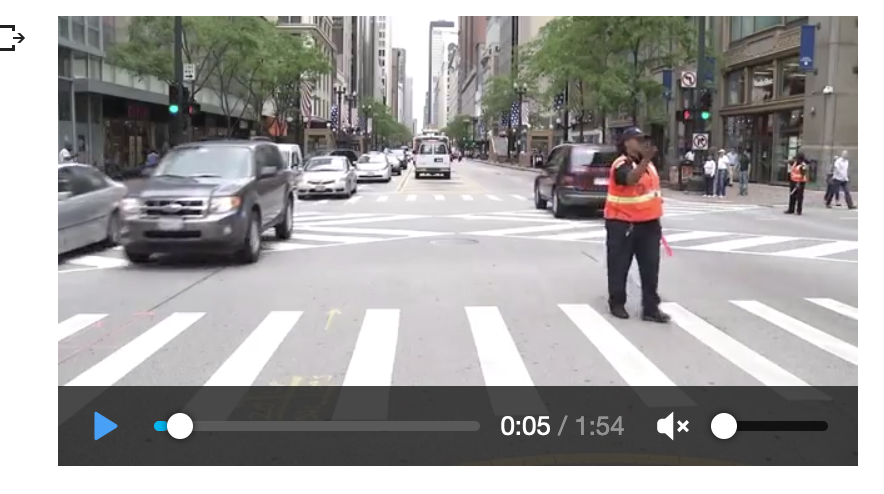

# (3) Object Detection



## (3.1) Helper functions to get and show the atributes of the video file

In [23]:
def get_video_attributes(video):
  frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
  fps = int(round(video.get(cv2.CAP_PROP_FPS),0))
  fourcc = int(video.get(cv2.CAP_PROP_FOURCC))
  fourcc_char = "".join([chr((int(fourcc) >> 8 * i) & 0xFF) for i in range(4)]).upper()
  frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

  return (frame_height, frame_width, fps, fourcc, fourcc_char, frame_count)

### Function test
video_cap = cv2.VideoCapture(input_video) 
h,w,f,c,cc,fc = get_video_attributes(video_cap)
video_cap.release()

print(h,w,f,c,cc,fc)

360 640 30 828601953 AVC1 3407


In [24]:
def show_video_attributes(vf):
  vfcap = cv2.VideoCapture(vf)
  h,w,f,c,cc,fc = get_video_attributes(vfcap)
  display(Markdown(f">1. Height: {h} px\n  >2. Width: {w} px\n >3. Frames Per Second: {f}\n >4.Number of Frames: {fc}\n >4.Video Codec: {cc} "))
  vfcap.release()

### Fucntion Test
show_video_attributes(video_1)

>1. Height: 360 px
  >2. Width: 640 px
 >3. Frames Per Second: 30
 >4.Number of Frames: 2648
 >4.Video Codec: AVC1 

## (3.2) Main function to detect `cars` using Haar based cascade classifier.

In [27]:
car_cascade = cv2.CascadeClassifier('cars.xml')
vcap = cv2.VideoCapture(input_video)

temp_video = os.path.join(project_path,'_video_temp.mp4')
out_video = os.path.join(project_path,'out_'+video_1.split("/")[-1])
# print(input_video, out_video)

if os.path.exists(temp_video):
  print("Removing temp files")
  os.remove(temp_video)
if os.path.exists(out_video):
  print("Removing stale files")
  os.remove(out_video)

frame_height,frame_width,fps,source_fcc,source_fcc_char, frame_count = get_video_attributes(vcap)
# print(frame_height,frame_width,fps,source_fcc,source_fcc_char, frame_count )
display(Markdown(f"#### Video Attributes Discovered from the source video : \n >1. Height: {frame_height} px\n  >2. Width: {frame_width} px\n >3. Frames Per Second: {fps}\n >4.Number of Frames: {frame_count}\n >4.Video Codec: {source_fcc_char} "))
target_fourcc = cv2.VideoWriter_fourcc(*'MP4V')
vout = cv2.VideoWriter(temp_video, target_fourcc, fps, (frame_width,frame_height), True)

pbar = tqdm(total = frame_count)

while(vcap.isOpened()):
  ret, frame = vcap.read()
  if ret == True:
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    cars = car_cascade.detectMultiScale(gray,1.1,5)
    for (x,y,w,h) in cars:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, 'Car', (x + 6, y - 6), font, 0.5, (0, 0, 255), 1)

    vout.write(frame)
    pbar.update(1)
   
  else:
    break

pbar.close()
vcap.release()
vout.release()

sleep(5)

try:
  print("Decompresing in progress.... ")
  cmd_op = subprocess.call(['ffmpeg', '-i','%s'% temp_video, '%s'% out_video, '-y'])
except:
  print("Decompresion failed.... ")

if os.path.exists(temp_video):
    os.remove(temp_video)

if (os.path.exists(out_video)):
  display(Markdown(f"#### Video processing completed.... '{out_video}' with size {os.path.getsize(out_video)} Bytes created"))
  display(Markdown("#### Video Attributes Discovered from the target video :"))
  show_video_attributes(out_video)
  show_movie(out_video,size=600)
    
else:
  display(Markdown("#### Video Processing failed.... Try again"))





Output hidden; open in https://colab.research.google.com to view.

#(4) Conclusion:

> 1. Cars are clearly identified.
> 2. Although we see some amount of `false positives`, this could be fine tuned using the `scale` defaault value is `1.1` and `minNeighbors` default is `3`. We have set these params to `1.1` and `5` respectively to reduce the false positives.



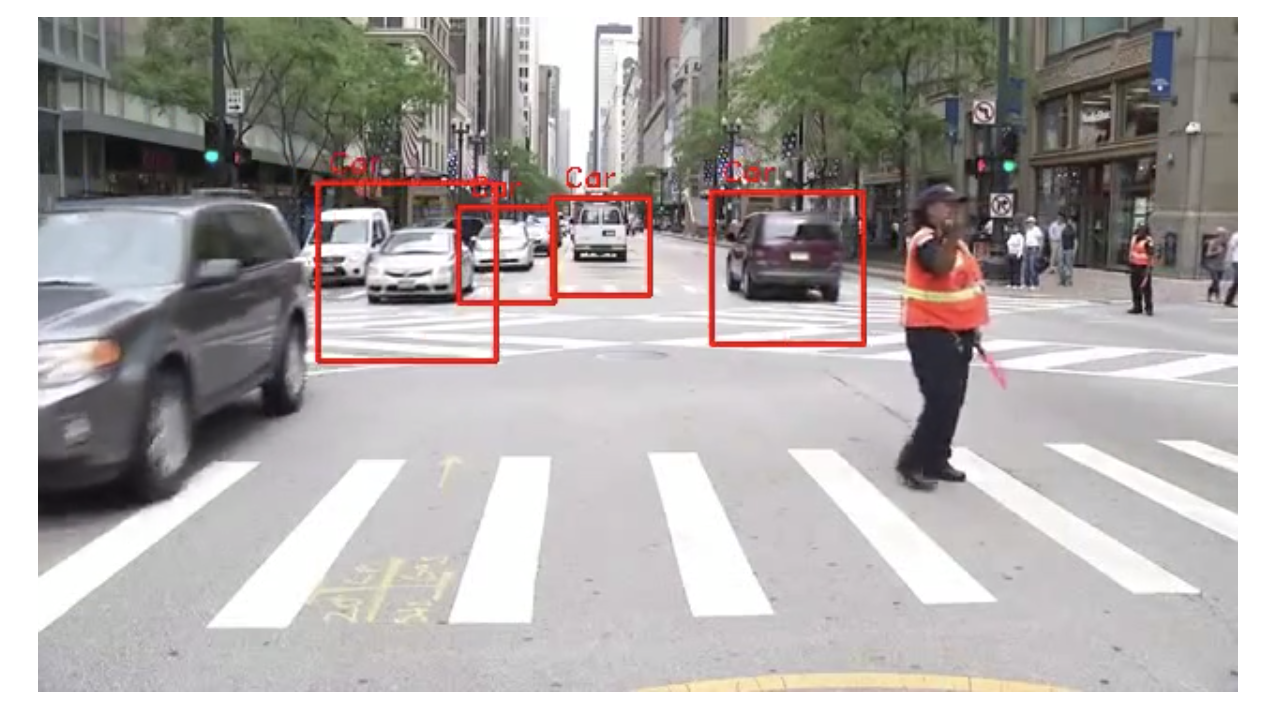